# Compression of generative art videos: h264, h265, VP8/9, AV1, and h266

We'll be analyzing a practical use case, video compression of Processing or P5js sketches with FFMPEG and h264 AVC, h265 HEVC, h266 VVC, VP8 and VP9, and AV1 codecs.

## Encoder choices

For h264, we'll be using libx264, though we can also use NVenc and kvazaar. For h265 we'll be using libx265, but NVenc is also a possibility.
For h266 we don't have yet FFMPEG support, but we can use the reference h266/VVC encoder and decoders.
VP8 and VP9 are provided via libvpx and libvpx-vp9 and finally AV1 support is provided via libaom-av1.

## Test Content

The creation of relevant good quality meaningful reference material for video compression testing is on itself a challenge due to the incredible number of options, parameters, use cases that need to be covered. What is good quality? Good quality on a 1m diagonal OLED display? Or on your mobile phone?
Is the content being streamed? Is latency critical? Or is the content stored offline, i.e, in a disc?
Settings that will work great with normal scenes will fail with high motion scenes.

Due to the countless encoding options and the combinatorial explosion of testing them all, we'll be focusing on a narrow subset of options targetting this specific use case - generative art videos which exhibit the following characteristics

 * Fast erratic or unpredictable movement
 * No motion blur
 * High frequency content, in some cases, with aliasing
 * High chromatic contrast and color purity
 * Cases with overlapping alpha blended unpredictable movement
 
Together with these test results, notebooks and source code you'll also find the source code for the P5js sketches that were used to create the reference source material.
The sketches were recorded and encoded with NVidia's hevc_nvenc using the GPU to keep the high throughput low latency required to record the processing intensive sketches without the introduction of lag.

## Reference Material Encoding and Characteristics

The source material was encoded with h265/HEVC lossless profile, intra frames only, with YUV 4\:4\:4 sampling, high tier mode to have good reference material attending the characteristics outlined above.
If needed, you can change the profile to a 10 or even 12bit profile. For these tests we remain with 8bit output.
Colorimetry was set to Rec.709 RGB primaries, D65 whitepoint, but with the sRGB IEC-61922-6.1 CCTF.

## Types of Video Quality Metrics

Like with the creation of meaningful content for tests, the metrics used are and have been an area of active and ongoing research for quite some time. Both content and video quality assessment are actives areas of research under several groups, including the VQEG or Video Quality Experts Group. We cannot cover all of this in-depth but we'll provide a brief assessment of the main families of techniques and the ones we'll be using in the tests that we'll be running.

Succintly, there are **objective** and **subjective** quality models. Objective models can be measured free from human interpretation, and can be divided according to what signal we have available to test.
Subjective models requires the viewers opinion of the quality of the video being watched and a mean score given.


### Full Reference Methods

This method compares the encoded signal with a original reference signal and quantifies the difference according to specific metrics. Since they require both the original and the compressed signals, they cannot be used everywhere and since they measure pixel differences, there is heavy computational cost involved.

### Reduced Reference Methods

Similar to the **Full Reference Method**, except there's no access to the entire original signal, or due to constraints, it's impractical to acess it all.

### No Reference Methods

Are used to assign a quality indication of the compressed signal without access to the original material. They are usually lighter to compute. 
These are divided into
 * Pixel Based Methods - try to quantify the image quality or degradation due to blurring, motion blur, other artifacts
 * Parametric or Bitstream Methods - these have access to encoding data, parameters, motion vectors and other related data and try to access the signal quality according to these. They're not accurate, but provide a good fast approximated indication.
 * Hybrid Methods - combine both the pixel based methods and the parametric or bitstream methods.
 

## Methodology

### Video Quality Metrics Used

Since we have access to the original source material and the compressed material we'll be generating, and performance is not critical, it makes sense to use full reference methods.
Of these, the metrics we'll be using are:

 * PSNR - Peak Signal to Noise Ratio. Due to the characteristics of the HVS, PSNR is not a reliable indicator of perceived quality.
 * SSIM - Structural Similarity. SSIM measures perceived change in structural information, including luminance and contrast masking, it takes the HVS characteristics into consideration and is a more reliable indicator of perceived quality than PSNR.
 * VMAF - Video Multimethod Assessment Fusion, is a metric developed by NetFlix, composed of 4 distinct features which are fused via SVM or Suport Vector Machine, a type of supervised machine learning model used for data classification and regression analysis. These features are:
   * VIF or Visual Information Fidelity, which considers information loss in 4 different spatial scales
   * DLM or Detail Loss Metric, measures loss of details
   * MCPD or Mean Co-located Pixel Difference, measures the temporal difference on the luminance component
   * ANSNR or Anti-Noise Signal-to-Noise Ratio, abandoned in new VMAF versions.
  
We'll also be using AI/ML for perceptual video quality assessment methods with [LPIPS](https://richzhang.github.io/PerceptualSimilarity/) metric - Learned Perceptual Image Patch Similarity, and with the [Berkeley-Adobe Perceptual Patch Similarity (BAPPS) dataset](https://github.com/richzhang/PerceptualSimilarity#2-berkeley-adobe-perceptual-patch-similarity-bapps-dataset), as well as PSNR-HVS-M, that is, Peak Signal To Noise Ratio taking into account Contrast Sensitivity Function (CSV) and in-between coefficient contrast masking of DCT basis functions - a PSNR metric that takes into account the HVS response.

### Encoding Options Used

As outlined earlier, we'll be restricting the options to the choice of:
 * presets
 * tuning
 * entropy encoding algorithms
 * rate control types
 * chroma subsampling
 
There are countless options to fine-tune the motion vector search algorithms, macroblocks sizes, and so on, but this would lead to thousands of files. It can be done, but in a automated, machine-assisted way that is outside the scope of this report.

#### Encoding Entropy Algorithm *(coder)* can be one of:

* [CABAC](https://en.wikipedia.org/wiki/Context-adaptive_binary_arithmetic_coding) - Context Adaptive Binary Arithmetic Coding
 * [CAVLC](https://en.wikipedia.org/wiki/Context-adaptive_variable-length_coding) - Context Adaptive Variable Length Encoding
 * [AC](https://en.wikipedia.org/wiki/Arithmetic_coding) - Arithmetic Coding
 * [VLC](https://en.wikipedia.org/wiki/Variable-length_code) - Variable Lenght Encoding

See [also this](https://learn.akamai.com/en-us/webhelp/media-services-on-demand/media-services-on-demand-encoder-best-practices/GUID-F3F0BD92-69C3-4B7F-BE84-A33BA138B55A.html)

#### Rate control, can be one of:

 * ConstQP - Constant Quantization P mode
 * [VBR](https://en.wikipedia.org/wiki/Variable_bitrate) - Variable Bit Rate
 * [CBR](https://en.wikipedia.org/wiki/Constant_bitrate) - Constant Bit Rate
 * CBR_LD_HQ - Constant Bit Rate with Low Delay, High Quality mode
 * CBR_HQ - Constant Bit Rate High Quality Mode
 * VBR_HQ - Variable Bit Rate High Quality Mode

#### [Chroma subsampling](https://en.wikipedia.org/wiki/Chroma_subsampling)

Can be YUV 4:2:0, 4:2:2, 4:4:4. The libx264 codec has more control over the macroblocks when compared with NVenc. Other codecs support other sampling modes, such as YUV 4:1:1, and quantization modes for 10bit, 12bit, 16bit signals, besides RGB.

In [1]:
#!ffmpeg -h encoder=libx264

## Video resources, configuration

Define a **VIDEO_RESOURCES** environment variable pointing to the location of your original videos, and **VIDEO_COMPRESSED** environment variable pointing to the location to use for storing the resulting compressed videos.

In [2]:
import media as md
import options as op
import os

In [3]:
# create a new Media object that has the configuration options, see help(md), dir(md)
media = md.Media()

In [4]:
print(f"source material dir:\n{media.input_dir()},\noutput dir:\n{media.output_dir()}") 

source material dir:
/home/cgwork/Downloads/Masters/Tecnologias_Comunicacao_Multimedia_TCM/Work/videos/original,
output dir:
/home/cgwork/Downloads/Masters/Tecnologias_Comunicacao_Multimedia_TCM/Work/videos/compressed


In [5]:
# we'll glob all the files under the input dir with the following extensions
print(media.containers())
media.glob_media()
media.input_files()

['mp4', 'mkv', 'webm']


['/home/cgwork/Downloads/Masters/Tecnologias_Comunicacao_Multimedia_TCM/Work/videos/original/light_orbitals.mkv',
 '/home/cgwork/Downloads/Masters/Tecnologias_Comunicacao_Multimedia_TCM/Work/videos/original/colored_orbitals.mkv',
 '/home/cgwork/Downloads/Masters/Tecnologias_Comunicacao_Multimedia_TCM/Work/videos/original/flowlock.mkv',
 '/home/cgwork/Downloads/Masters/Tecnologias_Comunicacao_Multimedia_TCM/Work/videos/original/flowfield.mkv',
 '/home/cgwork/Downloads/Masters/Tecnologias_Comunicacao_Multimedia_TCM/Work/videos/original/noiseywaves.mkv']

In [6]:
# same for the output files
#media.output_files()

We can view a video thumbnail, for example, the first video in the list

In [7]:
import ffmpeg

from ipywidgets import interact
from matplotlib import pyplot as plt
import ipywidgets as widgets
import numpy as np

In [8]:
# get the information from the files in the object input list into a dictionary
info = media.info()

In [9]:
# get the width and height of the first media file in the input list
width = media.width(media.input_files()[0])
height = media.height(media.input_files()[0])
print(f"input file {media.input_files()[0]} height is {height}, width is {width}")

input file /home/cgwork/Downloads/Masters/Tecnologias_Comunicacao_Multimedia_TCM/Work/videos/original/light_orbitals.mkv height is 720, width is 1280


Prepare the widget for the thumbnail view with the FFMPEG python bindings and NumPy

In [10]:
out, err = (
    ffmpeg
    .input(media.input_files()[0])
    .output("pipe:", format="rawvideo", pix_fmt="rgb24", loglevel="error")
    .run(capture_stdout = True)
)

video = (
    np
    .frombuffer(out, np.uint8)
    .reshape([-1, height, width, 3])
)

@interact(frame=(0, media.number_of_frames(media.input_files()[0])))
def show_frame(frame = 0):
    plt.imshow(video[frame,:,:,:])

interactive(children=(IntSlider(value=0, description='frame', max=256), Output()), _dom_classes=('widget-inter…

Check codecs with ```ffmpeg -codecs``` and specific options with ```ffmpeg -h encoder=<encoder here>```, example for the h264 case, ```ffmpeg -h encoder=libx264```.
In our case, we're interested in h264, h264/HEVC, h266/VVC, VP8, VP9, AV1.

In [11]:
!ffmpeg -hide_banner -loglevel error -codecs|grep -wE 'av1|vp8|vp9|h264|hevc|vvc'

 DEV.L. av1                  Alliance for Open Media AV1 (decoders: libdav1d libaom-av1 av1 ) (encoders: libaom-av1 libsvtav1 )
 DEV.LS h264                 H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10 (decoders: h264 h264_v4l2m2m h264_cuvid ) (encoders: libx264 libx264rgb h264_nvenc h264_v4l2m2m nvenc nvenc_h264 )
 DEV.L. hevc                 H.265 / HEVC (High Efficiency Video Coding) (decoders: hevc hevc_v4l2m2m hevc_cuvid ) (encoders: libx265 nvenc_hevc hevc_nvenc hevc_v4l2m2m libkvazaar )
 DEV.L. vp8                  On2 VP8 (decoders: vp8 vp8_v4l2m2m libvpx vp8_cuvid ) (encoders: libvpx vp8_v4l2m2m )
 DEV.L. vp9                  Google VP9 (decoders: vp9 vp9_v4l2m2m libvpx-vp9 vp9_cuvid ) (encoders: libvpx-vp9 )
 ..V.L. vvc                  H.266 / VVC (Versatile Video Coding)


## Codec options

### H.264 | MPEG-4 AVC

We need to check the options for each family of codecs, though to keep it manageable, we'll be restricted to changing the macroblock size, and the number of intraframes, as well as perhaps the pixel format for specific luma and chroma subsampling. We might change the DCT, IDCT type, from fast integer to floating point, and do some analysis first of common metrics, then of new perceptual metrics, then using deep learning and reference free image quality metrics.

In [12]:
!ffmpeg -hide_banner -loglevel error -h encoder=libx264

Encoder libx264 [libx264 H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10]:
    General capabilities: delay threads 
    Threading capabilities: other
    Supported pixel formats: yuv420p yuvj420p yuv422p yuvj422p yuv444p yuvj444p nv12 nv16 nv21 yuv420p10le yuv422p10le yuv444p10le nv20le
libx264 AVOptions:
  -preset            <string>     E..V....... Set the encoding preset (cf. x264 --fullhelp) (default "medium")
  -tune              <string>     E..V....... Tune the encoding params (cf. x264 --fullhelp)
  -profile           <string>     E..V....... Set profile restrictions (cf. x264 --fullhelp) 
  -fastfirstpass     <boolean>    E..V....... Use fast settings when encoding first pass (default true)
  -level             <string>     E..V....... Specify level (as defined by Annex A)
  -passlogfile       <string>     E..V....... Filename for 2 pass stats
  -wpredp            <string>     E..V....... Weighted prediction for P-frames
  -a53cc             <boolean>    E..V....... Use A53 Closed C

### h265 | HEVC options

In [13]:
# hevc, libx265, kvazaar, hevc_nvenc
#!ffmpeg -hide_banner -loglevel error  -h encoder=libx265

The same criteria as with h264 apply.

### H.266 | VVC

It's known to FFMPEG, but without a supported encoder, yet, though patches exists in development branches.
Test with the official Fraunhoffer provided VVenc.
It seems to expect a YUV input video, already chroma subsampled in 4:2:0, 8, or 10bits

In [14]:
#!ffmpeg -hide_banner -loglevel error  -h encoder=vvc
#!vvencapp --help

### VP8, VP9, AV1

Open Media Alliance created VP8, VP9, VP1 to counteract the H.264|MPEG-4 AVC, H.265|HEVC potential licensing woes. H.266/VVC seems to be encumbered by licensing issues as well. VP8 was deprecated, superceded by VP9, which itself was superceded by AV1.


In [15]:
#!ffmpeg -hide_banner -loglevel error  -h encoder=vp8

### x264 options:

From the list of presets, *ultra\|super\|veryfast, faster, fast, medium, slow, slower, veryslow, placebo*, we'll use a subset and the same for the tuning presets: film, animation, grain, stillimage, psnr, ssim, fastdecode, zerolatency.

Since hardware constraints or streaming aren't considerations, the tuning will be restricted to *film, animation, grain*.

Chroma subsampling will be restricted to *YUV 4:2:0, YUV 4:2:2, YUV 4:4:4* with 8bit output.
With higher bitdepth source content we can use 10bit support,i.e, *yuv422p10le*, see ```x264 --fullhelp``` for an exhaustive list of options for the source material.

Range is set to *pc*, so 8bit material is in ```[0,255]``` range, instead of ```[16,235]```

Motion estimation an take the values:

 * *dia* - Diamond search, checks motion vectors one pixel up, left, down and right choosing the best candidate and repeated until no better motion vector is found.
 
 * *hex* - Hexagon like the Diamond search, but searches instead in a radius of two pixels for six adjacent points. It's a good default since it's more efficient than the Diamond search and is very efficient.
 
 * *umh* - Uneven Multi-Hexagonal search, has a ```--me-range``` parameter, defaulting to 16, to control the search radius, and is heavier than the regular Hexagonal search.
 
 * *esa* - Exhaustive search, an optimized search of the complete motion vector space within the ```--me-range``` parameter, which defaults to 16.
 
 * *tesa* - Transformed Exhaustive search, attempts to approximate the effect of running a Hadamard transform comparison at each motion vector.

Subpixel motion estimation will be left unchanged to mode 7, that is, Rate Distortion Optimization mode decision for all frames (I, P, B), but mode 9 and 10 will be tested later, that is, RD refinement for all frames, and quarter pixel RD, which requires Trellis RD quantization mode 2 via ```---trellis```

Use ```--slow-firstpass``` with multipass approaches to keep good quality analysis settings before the actual encoding takes place on the 2nd pass.

Use ```--b-adapt``` with value 1=*Fast*, 2=*Optimal*, default being one, for the adaptive B-frame decision method.

Use ```--keyint``` with an integer for the maximum GOP size, 250 being the default.

Use ```--qp``` from 0 to 81, 0 being lossless, and ```--crf``` for quality based VBR, from -12 to 51, the default being 23.0.

Adaptive quantizatio method, ```--aq-mode``` 0 = Disabled, 1 = Variance AQ (complexity mask), 2 = Auto-Variance AQ, 3 = Auto-variance AQ with bias to dark values.

P-frame weighted prediction is controlled with ```--weightp```, taking the values 0 = disabled, 1 = enable only weighted references, 2 = enable both weighted references and duplicates.
 
Quantization matrices will be left unchanged to the default H.264/AVC quantization matrices, *flat*.

In [16]:
options = op.Options()

Encode options are the codec specific encoding options passed to FFMPEG.

Common options are the global/general FFMPEG encoding options.

Encoding sets are the sets of codec specific or global encoding options that will be iterated in order to generate compressed tests with multiple parameters.
Example, if you want to use *Constant Rate Factor* rate control mode to encode a H.264 video with libx264, and generate 4 outputs each with different CRF quality in order to evaluate the perceptual video quality metrics on each, you would store this in a ```key:value``` pair in the encoding sets, i.e: ```{"crf" : [12, 28, 40],...}```

In [17]:
#print(options.encode_options())
#print(options.common_options())
#print(options.encoding_sets())

Create an encoder object, and this will be our interface between the videos, the compressors and their options, and FFMPEG.

In [18]:
import encoder as enc

In [19]:
encoder = enc.Encoder(media, options)

In [20]:
# debug the output files
# encoder.encoding(media.input_files()[0], media.output_files()[0])
# encoder.encode_videos()
# encoder.encode_video(
#     media.input_files()[0], 
#     media.output_files()[0], 
#     {
#         **options.common_options(), 
#         **options.encode_options()
#     },
#     debug=False)

### Compressed Output

A full combinatorial analysis, besides a naif brute force approach, would be a daunting task.
Smarter approaches exist to use neural networks to identify the type of content and start exploring settings optimized for that family.
In our case we'll do tests for individual sets of parameters, run perceptual video quality metrics on them, and the other metrics outlined earlier, compare resulting metrics versus file size, and plot them.

We'll start by constant rate factor, presets, tuning presets, chroma subsampling methods, and motion estimation methods.

The CRF rate control can be capped, also known as *cap-constrained CRF* and this will be calculated according to the maximum target size we'll allow. 
Example, from a 50MiB file the desired target bitrate will be calculated, with the joining maximum rate and buffer size to keep the rate control constrained within a maximum 200% maximum rate.

#### Compressing and Calculating Metrics

We'll calculate the PSNR, SSIM, VMAF per frame metrics, store them into a Pandas dataframe and compute the mean and moving averages, plotting them next.

##### SSIM

https://jpegai.github.io/6-metrics/

Structured Similarity Index Matrix and Multi-Scale SSIM.

##### PSNR

Peak Signal to Noise Ratio

##### VIF

Visual Information Fidelity

##### VMAF score

Video Multimethod Assessment Fusion or VMAF score. The VMAF score will be using the model we've chosen to provides us a score, so what it's actually telling us will change a bit depending on the model. For our model, its predicting quality of the video on a 1080p display in a "living room environment", and presuming that the persons viewing distance is 3x the height of the screen (25cm monitor/TV height = 75cm viewing distance).
We consider a score of 20 to be very bad, and a score of 100 to be excellent (flawless). I would consider anything above 80 to be quite good, and above 90 to very close perfect/indistinguishable from the ref.

In [21]:
from ffmpeg_quality_metrics import FfmpegQualityMetrics as ffqm
import pandas as pd

Example, with a given test video

In [22]:
encoder.encode_video(
    media.input_files()[0], 
    media.output_files()[0], 
    {
        **options.common_options(), 
        **options.encode_options()
    },
    debug=False)

We'll be calculating the structural similarity index for this given video, and as a result we should have a dictionary with the metrics computed, each containing an array of dictionaries, each with the respective metrics and auxiliary values for each frame *n*

In [23]:
metrics = ffqm(
    media.input_files()[0],
    media.output_files()[0],
    progress = True)

In [24]:
metrics_data = metrics.calc(["ssim"])


ssim: 100%|███████████████████████████████████| 100/100 [00:01<00:00, 78.44it/s]


Now we convert to a Pandas DataFrame for quick monitoring.
**Note** that with a huge series of files to test and more metrics, it might take a bit of time, and it would make sense to save the metrics dictionaries output as JSON files, then at a later date to plot them, just load the JSON into a Pandas DataFrame, and do your Pandas operations there before plotting them.
Converting to a Pandas DataFrame before saving would make it harder to flatten as a JSON file.

In [27]:
# print(ssim)
df = pd.DataFrame.from_dict(metrics_data["ssim"])
df.tail()

,n,ssim_y,ssim_u,ssim_v,ssim_avg
252,253,0.950,0.955,0.929,0.944
253,254,0.950,0.955,0.927,0.944
254,255,0.951,0.956,0.931,0.946
255,256,0.950,0.956,0.932,0.946
256,257,0.949,0.956,0.931,0.945


Now to clean this up a bit, rename the *n* column as *frame*, set it as the index, and fill the NaN values at row 0 with 0.
Computing the mean, harmonic mean, and simple or exponential moving averages (i.e, per second (25 frames) or 2 seconds (50 frames)) might also give some insights on metric variation, since the per-frame statistics might be too noise, reflecting sudden changes in frame, scene or shot content, motion, image data.

In [28]:
if "n" in df.columns:
    df.rename(columns={"n" : "frame"}, inplace = True)
    df.set_index("frame", inplace = True)

#df.fillna(0, inplace = True)

The structural similarity index is meaningful on the relative luminance Y channel, and we can use the dataframe ```describe()``` method to get its arithmetic mean, minimum, maximum, and standard deviation from the mean, as well as the percentiles.

The arithmetic mean would therefore be a good final value for the **SSIM** metric for the analyzed video, but we can have a better grasp of what is going on by adding the simple and exponential moving averages as well and plotting everything.

In [29]:
df.describe()

,ssim_y,ssim_u,ssim_v,ssim_avg
count,257.000000,257.000000,257.000000,257.000000
mean,0.952257,0.955183,0.926304,0.944584
std,0.010840,0.005449,0.009118,0.008070
min,0.938000,0.944000,0.909000,0.932000
25%,0.942000,0.951000,0.918000,0.938000
50%,0.949000,0.956000,0.927000,0.944000
75%,0.961000,0.959000,0.934000,0.952000
max,0.979000,0.968000,0.948000,0.963000


The window for a SMA would be for instance, two seconds at the media frame rate, i.e, 50 (for 25 progressive frames media). Structured Similarity Index Matrix is applied generally over the relative luminance Y channel only, but the dataframe has the values for the U and V channels as well as their average.
We'll be applied the SMA(2*framerate) and EMA(framerate) over the *ssim_y* channel only.

In [30]:
media.framerate(media.input_files()[0])

25

In [31]:
#df.rolling(window=media.framerate(media.input_files()[0])).mean()
#df.ewm(span=media.framerate(media.input_files()[0])).mean()

framerate = media.framerate(media.input_files()[0])

df[f"ssim_y_sma{2*framerate}"] = df["ssim_y"].rolling(window=2*framerate, min_periods=2*framerate).mean()
df[f"ssim_y_ema{framerate}"] = df["ssim_y"].ewm(span=framerate, adjust=False).mean()

In [32]:
import cufflinks as cf

In [33]:
#  ['ggplot', 'pearl', 'solar', 'space', 'white', 'polar', 'henanigans']
cf.set_config_file(theme="pearl",sharing="private",offline=True)

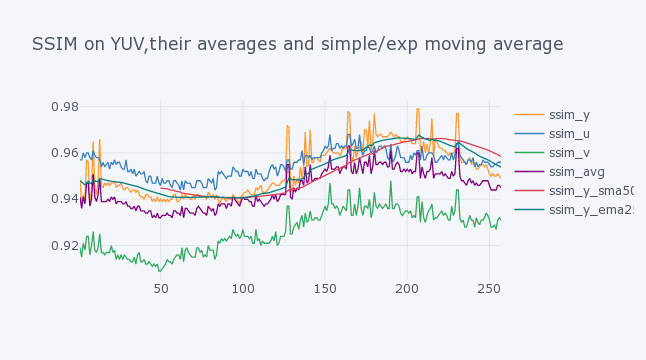

In [34]:
df.iplot(title="SSIM on YUV,their averages and simple/exp moving average")

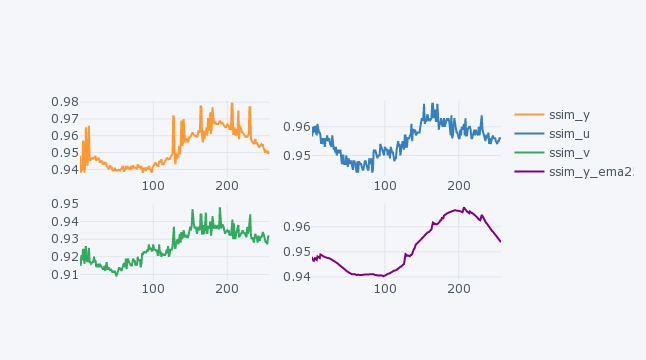

In [35]:
df.iplot(y=["ssim_y", "ssim_u", "ssim_v", "ssim_y_ema25"],subplots=True, width=2.0)

One thing we can see is that in general the SSIM values over the Y channel are above 0.94 for the entire length of the clip and spike to near 0.98 around the second half of the clip, as the moving averages also show, falling again.

Since we had a constant quality rate factor for this test, so instead of using a fixed value quantization matrix we allow it to vary as long as it is bounded by the crf value, for the given CRF value, compression was more efficient and retained more details compared with the original on the second half of the clip.

Another observation is that the the V channel had the same fluctuations but in general had much lower SSIM values than the U channel which was consistently above the V channel SSIM value. Noteworthy is also the more subdued impact of the adaptive quantization of the CRF mode on the U channel, since its variation is much less than the Y and V channel - around 0.005 standard deviations from the mean, compared with the V channel approx. 0.009.

In [36]:
# make a copy of the dataframe, transpose, prepare for a pie chart to compare the
# standard deviation to the mean of the SSIM for the Y, U, V channels.

df2 = (df.describe()).copy(deep=True)

df2.drop(columns=["ssim_y_ema25", "ssim_y_sma50", "ssim_avg"], inplace=True)

df2 = df2.transpose()

df2.reset_index(inplace = True)
df2.head()

,index,count,mean,std,min,25%,50%,75%,max
0,ssim_y,257.0,0.952257,0.010840,0.938,0.942,0.949,0.961,0.979
1,ssim_u,257.0,0.955183,0.005449,0.944,0.951,0.956,0.959,0.968
2,ssim_v,257.0,0.926304,0.009118,0.909,0.918,0.927,0.934,0.948


In [37]:
df2.rename(columns={"index" : "ssim"}, inplace=True)

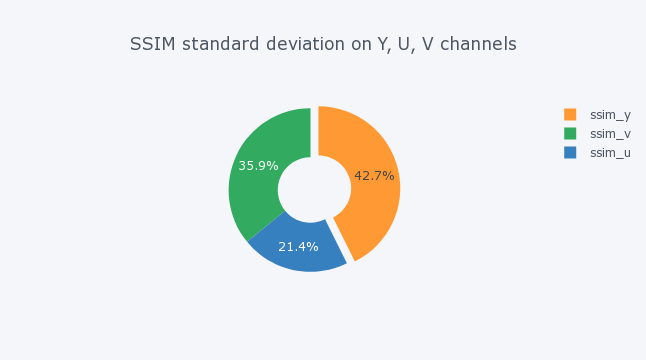

In [38]:
df2.iplot(kind="pie", labels="ssim", values="std", hole=0.4,
          pull=[0.1, 0, 0], title="SSIM standard deviation on Y, U, V channels")

##### Test and Export to JSON

Before proceeding with the full compression suite and analysis we'll be running the PSNR, SSIM, VMAF and VIF metrics on a reference video, export the data to a file as a JSON file, then load it and convert it to a Pandas DataFrame to avoid having to recompute everything for each compressed video.

In [39]:
metrics_data = metrics.calc(["psnr", "ssim", "vmaf", "vif"])


psnr, ssim, vmaf, vif: 100%|██████████████████| 100/100 [00:16<00:00,  5.99it/s]


In [42]:
import json

In [43]:
metrics_json = json.dumps(metrics_data, indent = 4) 
#print(metrics_json)

In [44]:
media.output_dir()

'/home/cgwork/Downloads/Masters/Tecnologias_Comunicacao_Multimedia_TCM/Work/videos/compressed'

In [45]:
fname = media.output_files()[0].split(".")[0] + ".json"

In [46]:
with open(fname, "w+") as f:
    f.write(metrics_json)

Now we can load the JSON file again, and create an array of Pandas DataFrames, each one for each metric.

In [47]:
metrics_dict = {}

with open(fname, "r") as f:
    metrics_dict = json.load(f)

In [48]:
vmetrics = ["psnr", "ssim", "vmaf", "vif"]
framerate = 25

dfs = {}

for metric in vmetrics:
    df = pd.DataFrame.from_dict(metrics_dict[metric])
    
    if "n" in df.columns:
        df.rename(columns={"n" : "frame"}, inplace = True)
        df.set_index("frame", inplace = True)
    
    if metric == "psnr":
        df["psnr_y_sma25"] = df["psnr_y"].rolling(window=framerate, min_periods=framerate).mean()
        df["mse_y_sma25"] = df["mse_y"].rolling(window=framerate, min_periods=framerate).mean()
        
    elif metric == "ssim":
        df["psnr_y_sma25"] = df["ssim_y"].rolling(window=framerate, min_periods=framerate).mean()
        
    elif metric == "vmaf":
        df["vmaf_sma25"] = df["vmaf"].rolling(window=framerate, min_periods=framerate).mean()
        df["ms_ssim_sma25"] = df["ms_ssim"].rolling(window=framerate, min_periods=framerate).mean()
        df["ssim_sma25"] = df["ssim"].rolling(window=framerate, min_periods=framerate).mean()
        df["psnr_sma25"] = df["psnr"].rolling(window=framerate, min_periods=framerate).mean()
    else:
        pass
    
    dfs[metric] = df.copy(deep = True)  # must be deep copy